In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

from itertools import chain, product

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Задание 1. Автоэнкодер для FashionMNIST c MSE-loss

В этом задании нужно обучить автоэнкодер на датасете FashionMNIST:

* Нужно полностью описать архитектуру энкодера и декодера. В класса декодера пусть на конце стоит сигмоида
* Не переопределяя класс уберите из декодера эту сигмоиду
* Используйте MSE-loss между реальным и восстановленным изображением
* Обучите автоэнкодер с размером латентного слоя 2.

Как выглядит латентное представление? 

Разделяются ли в нем классы? 

Далее:

*   Обучите автоэнкодер с размером латентного слоя 30
*   Продемонстрируйте восстановление автоэнкодером переданных ему изображений

* для визуализации латентного пространства буду юзать функцию `plot_manifold`,
* для визуализации восстановления изображений буду юзать функцию `plot_samples`.

________________________________
Прежде всего замучу эти функции + архитектуру.

In [2]:
def plot_manifold(latent_r, labels=None, alpha=0.9, classes=None):
    plt.figure(figsize=(10, 10))
    if labels is None:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], cmap="tab10", alpha=alpha)
    else:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], c=labels, cmap="tab10", alpha=alpha)
        cbar = plt.colorbar()
    if classes:
        cbar.ax.set_yticklabels(classes)
    plt.show()


# plotting reconstructed and noised images
def plot_samples(*args, invert_colors=True, digit_size=28, name=None):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[
                j * digit_size : (j + 1) * digit_size,
                i * digit_size : (i + 1) * digit_size,
            ] = args[j][i].squeeze()

    if invert_colors:
        figure = 1 - figure

    plt.figure(figsize=(2 * n, 2 * len(args)))
    plt.imshow(figure, cmap="Greys_r", clim=(0, 1))

    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig(name)
    plt.show()


def train(
    encoder,
    decoder,
    loader,
    optimizer,
    single_pass_handler,
    loss_handler,
    epoch,
    log_interval=500,
):
    for batch_idx, (data, lab) in enumerate(loader):
        batch_size = data.size(0)
        optimizer.zero_grad()
        data = data.to(device)
        lab = lab.to(device)

        latent, output = single_pass_handler(encoder, decoder, data, lab)

        loss = loss_handler(data, output, latent)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(loader.dataset),
                    100.0 * batch_idx / len(loader),
                    loss.item(),
                )
            )


# return reconstructed image, use to compute loss
def ae_pass_handler(encoder, decoder, data, *args, **kwargs):
    latent = encoder(data)
    recons = decoder(latent)
    return latent, recons


# loss function
def ae_loss_handler(data, recons, *args, **kwargs):
    return  F.mse_loss(recons, data)  #F.binary_cross_entropy(recons, data) 
# я слегка заменил


# return result in numpy to visualization
def run_eval(
    encoder,
    decoder,
    loader,
    single_pass_handler,
    return_real=True,
    return_recontr=True,
    return_latent=True,
    return_labels=True,
):

    if return_real:
        real = []
    if return_recontr:
        reconstr = []
    if return_latent:
        latent = []
    if return_labels:
        labels = []
    with torch.no_grad():
        for batch_idx, (data, lab) in enumerate(loader):
            if return_labels:
                labels.append(lab.numpy())
            if return_real:
                real.append(data.numpy())

            data = data.to(device)
            lab = lab.to(device)
            rep, rec = single_pass_handler(encoder, decoder, data, lab)
            if return_latent:
                latent.append(rep.cpu().numpy())
            if return_recontr:
                reconstr.append(rec.cpu().numpy())

    result = {}
    if return_real:
        real = np.concatenate(real)
        result["real"] = real.squeeze()
    if return_latent:
        latent = np.concatenate(latent)
        result["latent"] = latent
    if return_recontr:
        reconstr = np.concatenate(reconstr)
        result["reconstr"] = reconstr.squeeze()
    if return_labels:
        labels = np.concatenate(labels)
        result["labels"] = labels
    return result

In [3]:
import torch.nn as nn

# autoencoder model
class Encoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.latent_size = latent_size
        hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        modules = []
        in_channels = 1
        for h_dim in hidden_dims[:-1]:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=h_dim,
                        kernel_size=3,
                        stride=2,
                        padding=1,
                    ),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim

        modules.append(
            nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(),
            )
        )
        modules.append(nn.Flatten())
        modules.append(nn.Linear(hidden_dims[-1] * 4, latent_size))

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        hidden_dims = [512, 256, 128, 64, 32]
        self.linear = nn.Linear(in_features=latent_size, out_features=hidden_dims[0])

        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        hidden_dims[i],
                        hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(
                    hidden_dims[-1],
                    hidden_dims[-1],
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.BatchNorm2d(hidden_dims[-1]),
                nn.LeakyReLU(),
                nn.Conv2d(hidden_dims[-1], out_channels=1, kernel_size=7, padding=1),
                nn.Sigmoid(),
            )
        )

        self.decoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 512, 1, 1)
        # Дальше исправляю "Expected 3D (unbatched) or 4D (batched) input to conv_transpose2d, but got input of size: [64, 512]"
        #x=torch.reshape(x, (64, 512, 1, 1)) # 64 -- батч_сайз. Мб стоит потом глобально прописать это
        # так, это все было не нужно, я зафейлил, когда удалял сигмоиду
        x = self.decoder(x)
        return x

Теперь загружу данные и т.д.

In [4]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

root = "./data"

base = transforms.ToTensor()
train_set = FashionMNIST(root=root, train=True, transform=base, download=True)
test_set = FashionMNIST(root=root, train=False, transform=base, download=True)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
type(train_set)

torchvision.datasets.mnist.FashionMNIST

In [6]:
#torch.reshape(x, (64, 1, 32, 16))
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

В датасете 10 классов, каждый соответствует одному из предметов гардероба.

In [7]:
import numpy as np

# method for display all class samples from dataset
def show_ds(ds):
    fig, axs = plt.subplots(1, len(ds.classes), figsize=(20, 5))
    for cls_num, name in enumerate(ds.classes):
        i = np.argwhere(ds.targets == cls_num)[0][0]
        inverted = 255 - ds.data[i]
        ax = axs[cls_num]
        ax.imshow(inverted, cmap="Greys_r")
        ax.set_title(name)
        ax.axis("off")
    plt.show()

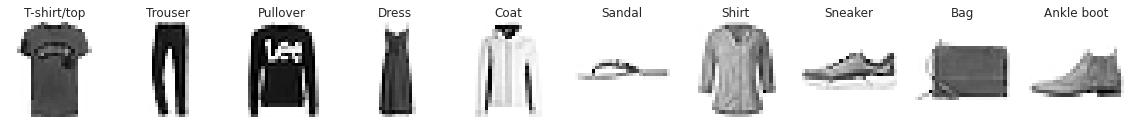

In [8]:
show_ds(test_set)

In [9]:
import torch.optim as optim
from itertools import chain

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(42)

latent_dim = 2 # size of latent space
learning_rate = 1e-4 
encoder = Encoder(latent_size=latent_dim)
decoder = Decoder(latent_size=latent_dim)

Посмотрю на декодер и не переопределяя класс уберу из декодера сигмоиду в конце.

In [10]:
decoder

Decoder(
  (linear): Linear(in_features=2, out_features=512, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2)

In [11]:
# что-то я здесь неадекватно хитрю. Потом тщательно поищу, как можно удалить какой-то слой из из Sequential() из архитерктуры
#decoder=torch.nn.Sequential(list(decoder.children())[0], *(list(decoder.children())[1][:-1]), *(list(decoder.children())[1][-1][:-1]) ) #torch.nn.Sequential(*(list(decoder.children())[:-1]))

# Тааак, это все мне сломало

In [12]:
# Видимо, правильно делать так
decoder.decoder[4][4]=nn.modules.Identity()

In [13]:
decoder

Decoder(
  (linear): Linear(in_features=2, out_features=512, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2)

Сигмоиду убрали. Дальше спокойно продолжаем подходить к обучению

In [14]:
encoder = encoder.to(device)
decoder = decoder.to(device)

optimizer = optim.Adam(
    chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
)


Обучаем:

In [15]:
for i in range(1, 6):
    train(
        encoder=encoder,
        decoder=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=ae_pass_handler,
        loss_handler=ae_loss_handler,
        log_interval=100,
    )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.487102
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.043268
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.037930
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.036898
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.037310
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.033745
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.035077
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.030222
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.031321
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.034163
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.034501
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.031490
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.030322
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.033016
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.030145
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.032428
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.031323
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.030546
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.032749
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.030520
Train Epoch:

Попробую чет нарисовать

In [16]:
encoder = encoder.eval()
decoder = decoder.eval()

In [17]:
run_res = run_eval(encoder, decoder, test_loader, ae_pass_handler)

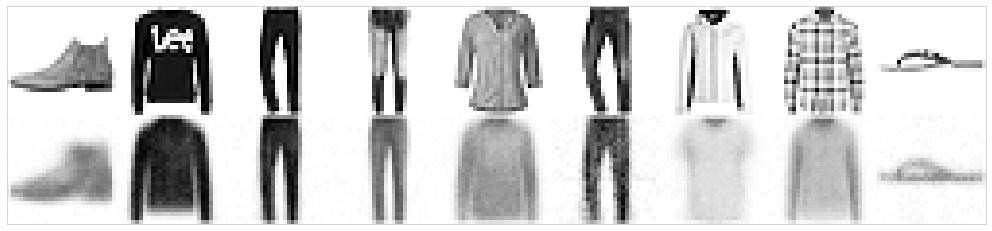

In [18]:
plot_samples(run_res['real'][0:9], run_res['reconstr'][0:9])

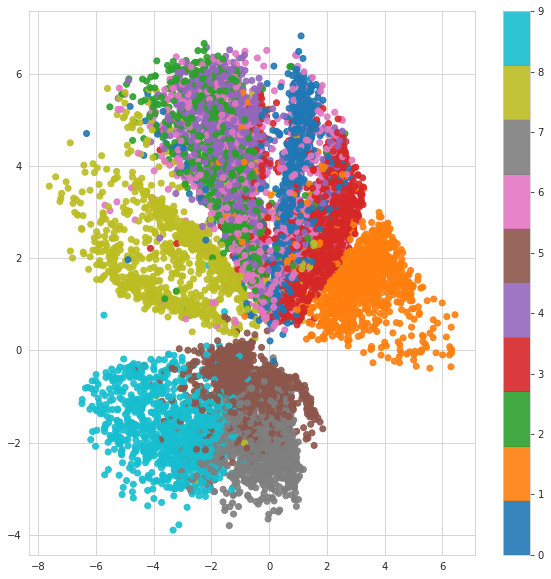

In [19]:
plot_manifold(run_res['latent'], run_res['labels'])

Теперь я обучу автоэнкодер с латентным пространством размерности 30, а не 2.

In [20]:
torch.manual_seed(42)

latent_dim = 30
learning_rate = 1e-4
encoder = Encoder(latent_size=latent_dim)
decoder = Decoder(latent_size=latent_dim)


encoder = encoder.to(device)
decoder = decoder.to(device)

optimizer = optim.Adam(
    chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
)

decoder.decoder[4][4]=nn.modules.Identity() # опять выбрасываю сигмоиду

for i in range(1, 6):
    train(
        encoder=encoder,
        decoder=decoder,
        optimizer=optimizer,
        loader=train_loader,
        epoch=i,
        single_pass_handler=ae_pass_handler,
        loss_handler=ae_loss_handler,
        log_interval=100,
    )

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.289288
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.034687
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.030545
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.028036
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.026326
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.020901
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.024380
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.021496
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.022603
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.018754
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.018570
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.017676
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.022375
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.015237
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.015675
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.015685
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.016487
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.016894
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.013934
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.016780
Train Epoch:

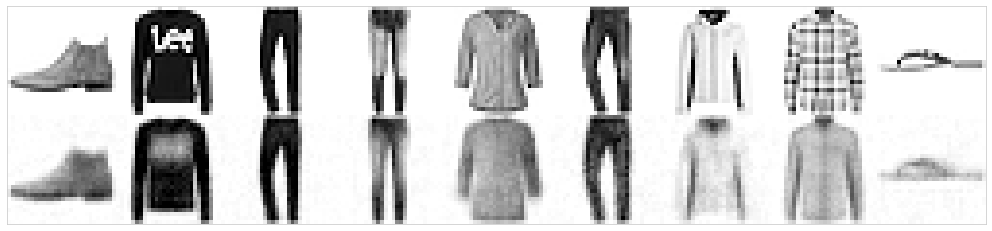

In [21]:
run_res = run_eval(encoder, decoder, test_loader, ae_pass_handler)

plot_samples(run_res['real'][0:9], run_res['reconstr'][0:9])

In [22]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=2948c0f6e2b93bc2bc2314d79406fa7244259c4474cdfeb40c204acd885d6744
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=b965d87f7bb35bfab9563744347a3acc1c429035fd15421e22d6746e4ca7b40f
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


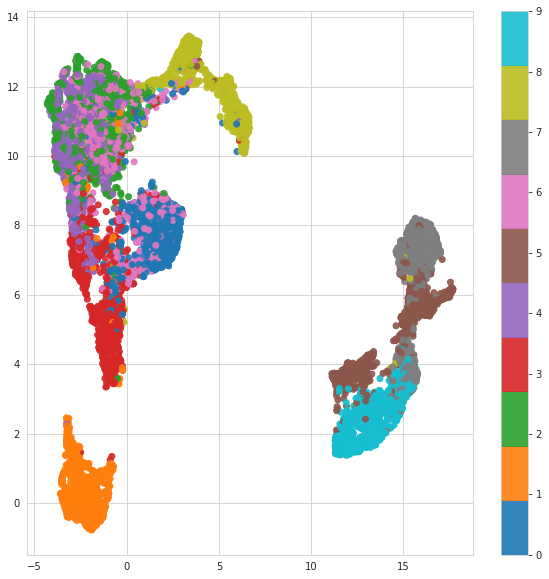

In [23]:
import umap
from sklearn.preprocessing import StandardScaler

reducer = umap.UMAP()
latent_30_to_2 = StandardScaler().fit_transform(run_res['latent'])
latent_30_to_2 = reducer.fit_transform(latent_30_to_2)

run_res
plot_manifold(latent_30_to_2, run_res['labels'])#plot_manifold(run_res['latent'], run_res['labels'])